In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import recall_score, precision_score, accuracy_score


In [2]:
df = pd.read_csv('../data/merged.csv')

In [3]:
df.shape

(22297, 9)

Dropping unnecessary columns, rearranging position of remaining columns, and reseting index.

In [4]:
df = df.drop(['author', 'num_comments', 'score', 'is_self', 'timestamp', 'year', 'month'], axis = 1)

In [5]:
df = df.loc[:,['fulltext','subreddit']]

In [6]:
df.reset_index(drop=True, inplace=True)

In [7]:
df

,fulltext,subreddit
0,Closing time.,0
1,Drama with hooking up at work I hooked up with...,1
2,Customers don't Read #1: Soda Water Eggs Chips...,0
3,Any tips for. Newbie on memorizing a menu?,1
4,"No, I'm not giving you another free giveaway. ...",0
...,...,...
22292,"That's right Sir, it's my fault you can't use ...",0
22293,"Blame the ""unfriendly cashier"", it's not like ...",0
22294,Funny little story from my time in retail. Sho...,0
22295,"Sons of Un-Ar-Key and explaining how Buy 3, Ge...",0


In [8]:
#tokenizer = RegexpTokenizer(r'\w+')

In [9]:
#tokens = tokenizer.tokenize(f)

Declaring predictor variable "fulltext", where each observation (row) represents the combination of title and post text for a given post. Declaring target variable "subreddit", where each observation is a binarized representation of whether the text comes from "TalesFromYourServer" reddit (1), or the "TalesFromRetail" reddit (0). 

In [10]:
X = df['fulltext']
y = df['subreddit']

Checking the the normalized value counts from our data to see how balanced our data classes are. Luckily, our data is almost perfectly balanced each with each value having close to 50% of the total count, which will act as our baseline score. 

In [11]:
y.value_counts(normalize = True)

0    0.501278
1    0.498722
Name: subreddit, dtype: float64

We split our test data with a random state of – with an arbitrary number, in this case, 42 – to making our answers replicable. 

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 42)

Instantiating our TFIDF (term frequency-inverse document frequency) vectorizer. With foundations similar to a CountVectorizer this goes beyond the standard bag-of-words approach, increasing the value of a tokenized word if occurs it frequently in fewer documents, while decreasing the value of more ubiquitous terms. We will use english arguement for our stop_words parameter, removing common English words based on a predetermined list which stored in the TFIDF transformer. 

In [13]:
tvec = TfidfVectorizer(stop_words='english', strip_accents = 'ascii')

We fit and transform our vectorizer over our training predictor variables, while just transforming our testing predictor data. 

In [14]:
X_train_tvec = tvec.fit_transform(X_train)
X_test_tvec = tvec.transform(X_test)

Create two seperate dataframes, and by using the .todense method, are able to save memory by consolidating the sparse matrix which is currently representing our vectorized text.

In [15]:
X_train_tvec_df = pd.DataFrame(X_train_tvec.todense(),columns=tvec.get_feature_names())
X_test_tvec_df = pd.DataFrame(X_test_tvec.todense(),columns=tvec.get_feature_names())

Double check the shape of the training and testing data to make sure they have the same amount of features, and their rows add up to 22,297. Also checking for nulls. 

In [16]:
X_train_tvec_df.shape

(16722, 37332)

In [17]:
X_test_tvec.shape

(5575, 37332)

In [18]:
X_train_tvec_df.isnull().sum().sum()

0

In [19]:
X_test_tvec_df.isnull().sum().sum()

0

Instantiating a logistic regression model, fitting the model over our training data, and then scoring it on both the training and test data. 

In [20]:
logreg = LogisticRegression()

In [21]:
logreg.fit(X_train_tvec_df, y_train)

LogisticRegression()

Our logistic regression model scored close to 94% accuracy on our training data, and approximately 91% on our testing data. These are pretty good scores considering we are using unscaled variables without adjusting any of the logistic regression model hyperparameters. Furthermore we can also tell that our model is overfit, with the testing data's accuracy score four percent lower than the training data; which suggests our model suffers due to high variance. 

In [22]:
logreg.score(X_train_tvec_df, y_train)

0.9372084678866164

In [23]:
logreg.score(X_test_tvec_df, y_test)

0.9104932735426009

I delcare coefficients as a concatenation of a the column names (the vectorized words), and their corresponding, exponentiated coefficients. 

In [24]:
coefficients = pd.concat([pd.DataFrame(X_train_tvec_df.columns), 
                          pd.DataFrame(np.transpose(np.exp(logreg.coef_)))],
                          axis = 1)

Both columns have the same name so I have to use a function to give them unique names.

In [25]:
def df_column_uniquify(df):
    df_columns = df.columns
    new_columns = []
    for item in df_columns:
        counter = 0
        newitem = item
        while newitem in new_columns:
            counter += 1
            newitem = "{}_{}".format(item, counter)
        new_columns.append(newitem)
    df.columns = new_columns
    return df

In [26]:
coefficients = df_column_uniquify(coefficients)

In [27]:
coefficients.columns

Index([0, '0_1'], dtype='object')

In [28]:
coefficients = coefficients.rename(columns={0 : "word", "0_1" : "coefficient_value"})

The coefficients dataframe is put through the function, which differentiates our columns, and sort our values becomes possible.

We sort our coefficients by value. The first list sorts the coefficients in desending order. The second places them in descending order.

The coefficients that best indicate whether a reddit post was written by a server instead of a retail worker are perhaps obvious, and certainly telling. Servers distinguish themselves by refering to their place of employment (restaurant), themselves (server), the way the reference their cusomters (table), and their incentives (tip and bar). 

Terms that are most indictative of not being written by a server (and therefore a retail worker) also include a lot of innocous work references, but are indeed more specific to the realm of the retail domain. The place of work (store), the type of work they are doing (retail), how they refer to their cusomters (customers), as well as their positions and objects they interact with. Worth mentioning that "lady" is more associated with retail than service. 

In [29]:
coefficients.sort_values(by='coefficient_value', key=abs, ascending = False).head(10)

,word,coefficient_value
27500,restaurant,22360.267641
29158,server,12785.183319
32438,table,5027.068066
29170,servers,983.481728
33449,tip,639.902982
3930,bar,295.969239
33463,tips,150.831142
32443,tables,145.470156
29184,serving,110.309488
33460,tipping,106.005107


In [30]:
coefficients.sort_values(by='coefficient_value', key=abs, ascending = True).head(10)

,word,coefficient_value
31577,store,0.000013
27569,retail,0.003048
9081,customer,0.012311
15308,gt,0.027888
6262,cashier,0.036196
26977,register,0.048041
18081,items,0.061540
29534,shop,0.064069
9755,department,0.066944
18935,lady,0.073607


In [31]:
X_train_tvec_df = pd.DataFrame(tvec.fit_transform(X_train).todense(), 
                          columns=tvec.get_feature_names())

The most common words between both datasets were reasonably present and widely applicable in both contexts.

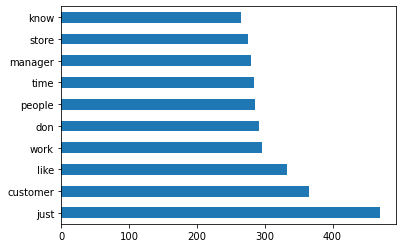

In [32]:
X_train_tvec_df.sum().sort_values(ascending=False).head(10).plot(kind='barh');

Predictions are made through our logistic regression model, using our text data from our testing set, and then stored in a dataframe.

In [33]:
preds = logreg.predict(X_test_tvec_df)

In [34]:
preds = pd.DataFrame(preds)

Our true negatives, false postives, false negatives, and true positives are declared as our confusion matrix is set up. The confusion matrix is then plot using the plot_confusion_matrix function from sci-kit learn on our testing data. 

In [35]:
#tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

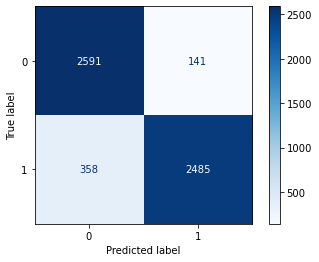

In [36]:
plot_confusion_matrix(logreg, X_test_tvec_df, y_test, cmap='Blues');

### Metrics

#### Accuracy

This metric is the ratio of number of correct predictions over the total number of predictions made.  

In [37]:
accuracy_score(y_test, preds)

0.9104932735426009

#### (Sensitivity) Recall

The sensitivty metric measures the amount of correct positive predictions (in this case, posts from the server subreddit) over all of our possible positive predictions. This is also considered the true positive rate. 

In [38]:
recall_score(y_test, preds)

0.874076679563841

#### Precision

Precision is the ratio that tells us the rate at which we correctly predicted posts over all the posts we predicted came from the server subreddit. 

In [39]:
precision_score(y_test, preds)

0.9463061690784463

Scaling our data before instantiating and fitting our K-Nearest Neighbors classifier from sci-kit learn.

In [40]:
#instantiate StandardScalar
sc = StandardScaler(with_mean=False)

sc_X_train = sc.fit_transform(X_train_tvec_df)
sc_X_test = sc.transform(X_test_tvec_df)

In [41]:
knn = KNeighborsClassifier(n_neighbors = 5) 
knn.fit(sc_X_train, y_train)

KNeighborsClassifier()

Scoring our model on both the training and test data.

In [ ]:
knn.score(sc_X_train, y_train)

In [ ]:
knn.score(sc_X_test, y_test)

Our KNN model had a training score of 62.5% and a test score 54.0%. Not only do these scores illustrate how wildly little predicitive power our models have, they also suffer from significantly higher variance, making them even more overfit than our logistic regression models. Granted, this model didn't maximize hyperparameter tuning, but given its poor intital performance (and massive computational cost for my puny Mac laptop) we will forgo using this model as our production model and will defer to the previously explored logistic regression model. The logistic regression model has the additional advantage of having interprettable coefficients.  